# Final project

- Yifei Chen (yc3832)     yc3832@columbia.edu

- Zujun Peng (zp2224)     zp2224@columbia.edu

- Yu Liu (yl3738)         yl3738@columbia.edu

## Business Objective

### Overall Buisiness Objective
Our overall objectvie is to apply various algorithms and models in the recommendation system to build a hybrid model that accurately predicts the user's rating on movies and make recommendation to them. Our model uses MovieLens latest datasets that collect preferences or tastes information from users previous rating as well as the genre information about the movies. Our primary and focusing objective of the hybrid model is to give a recommendation that reaches high accuracy and balance popularity, coverage, and novelty at the same time for all groups of using, including cold-start user.

We believe that the accuracy, popularity, and item coverage will contribute to the business profit, one of the most important driving forces in real-world business operation, produced by the recommendation system.

### Hybrid Model Outline
To reach our overall objective, we build a hybrid model utilizing various algorithms including content-based algorithm, matrix facterization algorithm, and facterization machine algorithm. 

Our hybrid model is a switching model since we apply different algorithms to different group of users. To be more specific, we divide users into three groups by the number of their historical ratings in the record. For users with only a few ratings or cold-start users, we apply content-based algorithm to build their prediction and recommendation, Users with a moderate amount of ratings are funneled into a matrix facterization model. Finally, we utilize facterization machine to power users who have rated a lot of movies in our dataset. 

We believe this hybrid model is feasible and comprehensive frist because our matrix facterization algorithm performed well in HW2 with a high accuracy and coverage. Moreover, content-based model is a good choice for cold-start problem for items and even for users if user profile is complete. This feature has practical meaning since new movies comes out frequently in the median industry in real world. Furthermore, facterization machine algorithm that envoles more interactions among variables and data allow us to better explore the original data and thus produce better recommendation.

### Evaluation Metrics
To build a recommendation algorithm with high accuracy, we choose to evaluate our algorithms by two accuracy metrics. The primary accuracy metric is the error metric Root-Mean-Square Error (RMSE), and the secondary one is the ranking metric, Normalized Discounted Cumulative Gain (NDCG). In addition to accuracy metrics, we calculate the item coverage and list Top 10 movies that have been recommended most at the end of the evaluation. We believe this evaluation can help us balance the popularity and item coverage of recommendation to some extent. 

### Intended Users
Since we build a hybrid model that applys different algorithms for users in different groups based on their historical ratings numbers, our intended users will be users with all levels of rating numbers. However, even though our model works for cold-start users, users with complte profile are preferred in order to make the content-based algorithm work well. Therefore, cold-start users with a few rating records may get more accurate and preferable recommendation if their profile information is complete or accessable from outside sources.

### Other Business Rules
During the sampling process for Homework 2, we remove movies rated less than a specific number of times (the default setting is 50). The number 50 is chosen by analyzing the rating counts over movies.  However, for the final project, we reduce this number to 30 since we now apply a content-based algorithm which works well for movie with a few ratings. However, we will remove movies with rating less than 30 becuase we believe that this number take popularity and coverage into consideration. Moreover, there are uncertainties about those movies' qualities for movies with few ratings. Recommending those movies to users might negatively affect users' opinions on our recommendation system. Therefore, we apply this sampling method to guarantee that we only recommend movies with at least 30 ratings in the rating records.

### Coding and  Performance Requirements: 
Since our model is a hybrid model that contain more advanced and complex algorithm, we need to make our code as concise and reusable as possible as well as considering efficient data stucture and function implementation to reduce unnecessary waste of running time. More importantly, we need to keep the consistency of training, validation, and testing datset 
in order to build a well-structed and coherent hybrid model.

Moreover, our model tries to balance time complexity and accuracy during the hyper-parameter tuning process and the evaluation process. Because of the large amount of rating data and limited computing power, we discard hyper-parameter values that contribute little to the overall accuracy while increasing the running time to a large extent. To ensure the overall efficiency during the model construction process, we first do a sanity check over a small dataset to ensure the algorithms work and then turn to a large dataset and evaluate the models.



## Construction of Hybrid Model

In [1]:
# Package Installation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score

# Need to install pyspark
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.session import SparkSession
from pyspark.context import SparkContext
#sc = SparkContext('local')
#spark = SparkSession(sc)

# Import packages for content-based recommender system
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Import packages for factorization machine
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, normalize
from pyfm import pylibfm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict
from sklearn.metrics import ndcg_score
from sklearn.metrics import dcg_score

### Read Data file
We use two data files "ratings.csv" and "movies.csv" that contain data on user IDs, movie IDs, ratings, and movie genres in our model.

In [2]:
# Import and Pre-process the datasets
ratings = pd.read_csv("./ratings.csv")
movies = pd.read_csv("./movies.csv")

# Replace 'no genres listed' with ""
movies['genres'] = movies['genres'].replace("(no genres listed)", '')
movies['genres'] = movies['genres'].str.replace("|", " ")

In [3]:
# Exploration on the dataset
ratings.info()
ratings = ratings.drop(columns = ['timestamp'])
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


### Exploratory Data Analysis on Users and Movies

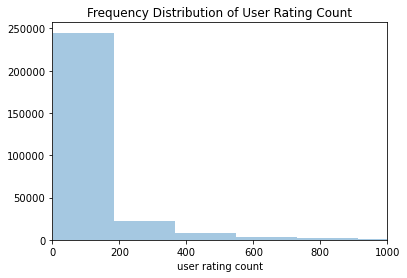

In [4]:
# Exploratory Data Analysis on user
user_count = ratings['userId'].value_counts()
sns.distplot(user_count, bins = 130, axlabel = "user rating count",label="frequency", kde = False).set_title("Frequency Distribution of User Rating Count")
plt.xlim(0, 1000)
plt.show()

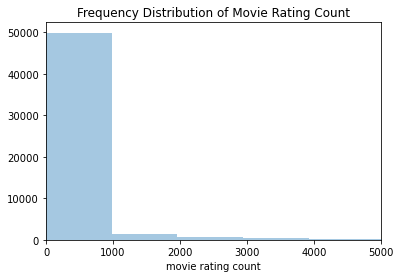

In [5]:
# Exploratory Data Analysis on movie
movie_count = ratings['movieId'].value_counts()
sns.distplot(movie_count, bins=100, axlabel = "movie rating count",label='frequency', kde = False).set_title("Frequency Distribution of Movie Rating Count")
plt.xlim(0, 5000)
plt.show()

Percentage of (movie rating count < 50) in (movie rating count < 1000) = 0.8112614596260859


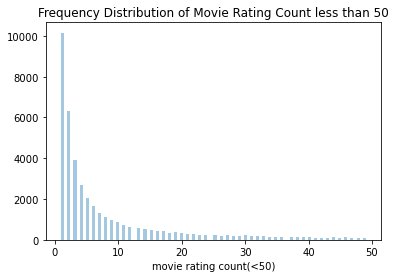

In [6]:
# Explore movie_count < 50
print('Percentage of (movie rating count < 50) in (movie rating count < 1000) =', sum(movie_count<50)/sum(movie_count<1000))
sns.distplot(movie_count[movie_count<50], bins=100, axlabel = "movie rating count(<50)",label='frequency', kde = False).set_title("Frequency Distribution of Movie Rating Count less than 50")
plt.show()

### Data and Cross Validation Setup
In this section, we write functions to sample dataset from the original file and set up cross validation.

First, we write a function to sample data from the original data file. As we discussed before, we only keep movies that have been rated more than a specific number (default value is 30) to ensure the quality of movie recommendation as well as getting well-prepared for content-based algorithm.

In [7]:
def sample_dataset(rating, nuser, min_item=30):
    """This function will sample a data set from the original data file

    Args:
        rate(data frame): The original data file that we are sampling from
        nuser(int): The number of user in the output sample
        min_item: only select movie with min_item rates or more, default is 50

    Returns:
        A sample from the original data file
    """
    data = rating.copy()
    
    # select users
    user_rc = data.groupby("userId").count()
    user_rc.reset_index(inplace = True)
    selectedu = user_rc.loc[:,'userId']
    selectedu = selectedu.sample(n= nuser, random_state = 0)
    data = data[data['userId'].isin(selectedu)]
    
    movie_rc = data.groupby("movieId").count()
    
    # select movie with min_item number of rates or more
    movie_rc.reset_index(inplace = True)
    movie_rc = movie_rc.rename(columns = {"rating": "count"})
    selectedm = movie_rc.loc[movie_rc['count'] > min_item, 'movieId']
    data = data[data['movieId'].isin(selectedm)]
    return data

The below functions transform the dataset into the proper form than can be used in the facterizatio machine. 

In [8]:
def data_for_fm(movies_data,ratings_data):
    """
    This function transform original data frame into a new data frame that will be used for faterization machine.
    Args:
      movies_data: data for movies and genres
      ratings_data: data for users, movies, and ratings
    Return:
      A new data frame that can be used in the facterization machine algorithm
    """
    df = movies_data.merge(ratings_data, on = 'movieId')
    g = df['genres']
    df_dummy = pd.get_dummies(g.apply(pd.Series).stack()).sum(level=0) 
    df = df[['movieId','userId','rating']]
    df_new = pd.concat([df, df_dummy], axis='columns')
    return df_new

In [9]:
def prepare_data_fm(movies_data,ratings_data):
    """
    This is also set up data for facterization machine
    """
    X = data_for_fm(movies_data,ratings_data)
    y = np.array(X['rating'])
    X = X.drop(['rating'], axis=1)
    return X, y

We then write the function to set up cross validation by dividing the sample dataset into training set, validation set, and test set with chosen ratio for each set.

In [14]:
# Train, test, validation split (validation ratio represents the ratio it holds in the training set)
def train_test_validation(dataset, train_ratio, test_ratio, validation_ratio):
    """This function set up the data set for cross validaton

    Args:
    daataset: original sample data
    train_ratio: ratio of training set
    test_ratio: ratio of test set
    validation_ratio: ratio of validation set

    Returns:
    Training dataset, testing dataset, and validation dataset
    """
    test_ratio = round(test_ratio/(1-train_ratio),2)
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    validation_df = pd.DataFrame()
    user_id_list = dataset['userId'].unique()
    for i in user_id_list:
        x = dataset.loc[dataset['userId'] == i]
        train = x.sample(frac = train_ratio, random_state = 0)
        rest = x.drop(train.index)
        test = rest.sample(frac = test_ratio, random_state = 0)
        validation = rest.drop(test.index)
        train_df = train_df.append(train)
        test_df = test_df.append(test)
        validation_df = validation_df.append(validation)
    return train_df, test_df, validation_df

Now we begin to sample our data from the original data file from the MovieLens dataset.

In [15]:
# Sample data with movies with at least 50 ratings
sample_large = sample_dataset(ratings, 25000, 30)
user_id_list = sample_large['userId'].unique()
movie_id_list = sample_large['movieId'].unique()
movie_num = len(movie_id_list)
user_num = len(user_id_list)
print("number of unique users for large sample data:", user_num)
print("number of unique items for large sample data:", movie_num)

number of unique users for large sample data: 24977
number of unique items for large sample data: 6576


We now get the movie list containing all the movie in our sample dataset. This list will then be used in the content-based algorithm.

In [16]:
# Select the movies that are in the sample dataset
movie_sample = movies[movies['movieId'].isin(movie_id_list)]
movie_sample = movie_sample.reset_index()
movie_sample['genres'] = movie_sample['genres'].str.split(" ")

Cross validation setup:

In [17]:
# Split sample data into training data, validation data, and test daya
train_ratio = 0.8
train_df, test_df, validation_df = train_test_validation(sample_large, train_ratio, 0.1, 0.1)

###  Evaluation methods set up
During the evaluation process, we will choose error metric, Root-mean-square error (RMSE), as our primary accuracy metric, and choose Normalized Discounted Cumulative Gain(NDCG) as our secondary accuraccy metirc. The following functions compute the value of our evaluation metric for different algorithms in our hybrid model.

In [18]:
def get_rmse(df_prediction):
    """
    This function computes the RMSE of the prediction
    Args:
    df_prediction: data frame of movieId, userId, rating, predicted rating
    Returns:
    RMSE value
    """
    df=df_prediction.copy()
    df.columns = ['uid', 'mid', 'rating', 'prediction']
    df['error'] = (df['prediction'] - df['rating'])**2
    df_rmse = (sum(df['error'])/len(df))**0.5
    return df_rmse 

In [19]:
def get_ndcg(data):
    """This function compute the NDCG of the model

    Args:
        data: the prediction data frame
    Returns:
        The NDCG score 
    """
    df = data.copy()
    df.columns = ['uid', 'mid', 'rating', 'prediction']
    df['relevance']=1
    df.loc[df['rating']<4,'relevance']=0
    gb = df.groupby('uid')   

    NDCG = 0
    for x in gb.groups:
        G = gb.get_group(x)
        rel = list(G['relevance'])
        pred = list(G['prediction'])
        if rel == [0]:
            ndcg = 0
        elif rel == [1]:
            ndcg = 1
        else:
            
            ndcg = ndcg_score(np.asarray([rel]),np.asarray([pred]))
            
        
        NDCG =  NDCG + ndcg

    
    NDCG = NDCG/(len(gb.groups))
    

    return NDCG

In [20]:
def fit_and_evaluate_mf(algo, train, test, ndcg = False, coverage = False):
    
    """This function compute RMSE, NDCG, and Item Coverage of the model

    Args:
        algo: model to be used
        train: training set
        test: testing set
        ndcg: a boolean to indicate the need to calculate ndcg
        coverage: a boolean to indicate the need to calculate item coverage

    Returns:
        RMSE for the model
        NDCG for the model(if indicated)
        Item Coverage and Top 10 recommended movies for the model 
        (if indicated)
    """
    model = algo.fit(train)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating",
                                    predictionCol = "prediction")
    rmse = evaluator.evaluate(predictions)
    
    if ndcg:
        prediction_ranking = predictions.toPandas()
        ndcg_result = get_ndcg(prediction_ranking)
        
    if coverage:
        # Recommend Top 10 movies for each user
        userSubsetRecs = model.recommendForUserSubset(test, 10)
        userRecs = userSubsetRecs.toPandas()
        test_movie = test.toPandas()
        test_movie_set = set(test_movie['movieId'])
        length = len(userRecs)
        rec = userRecs['recommendations']
        movie_rec = []
        movie_count = {}
        for i in range(length):
            user_length = len(rec[i])
            for j in range(user_length):
                ind_rec = rec[i][j]['movieId']
                movie_rec.append(ind_rec)
                try:
                    movie_count[ind_rec] = movie_count[ind_rec] + 1
                except:
                    movie_count[ind_rec] = 1
        # Change the list of recommended movie to a set of movies
        movie_rec = set(movie_rec)
        item_coverage = len(movie_rec)/len(test_movie_set)
    
    if ndcg and coverage:
        return rmse, ndcg_result, item_coverage, predictions
    elif ndcg and (not coverage):
        return rmse, ndcg_result
    elif (not ndcg) and coverage:
        return rmse, item_coverage, predictions
    else:
        return rmse

In [21]:
def get_top_n_mf(algo, training, test, n=10):
    model = algo.fit(training)
    userSubsetRecs = model.recommendForUserSubset(test, n)
    userRecs = userSubsetRecs.toPandas()
    length = len(userRecs)
    rec = userRecs['recommendations']
    movie_rec = []
    for i in range(length):
        user_length = len(rec[i])
        movie_list = []
        for j in range(user_length):
            ind_rec = rec[i][j]['movieId']
            movie_list.append(ind_rec)
        movie_rec.append(movie_list)
    userRecs['top_n'] = movie_rec
    userRecs = userRecs.drop(columns=['recommendations'])
    return(userRecs)

In [22]:
def fit_and_evaluate_fm(algo, traindata_onehot, testdata_onehot, X_train, X_test,
                        y_train, y_test, ndcg = False, coverage = False):
    """This function compute RMSE, NDCG, and Item Coverage of the model
    Args:
        algo: model to be used
        traindata_onehot: one hot encoded training set
        testdata_onehot: one hot encoded testing set
        X_train: training set
        X_test: testing set(validation set)
        y_train: target value of training set
        y_test: target value of testing set
        ndcg: a boolean to indicate the need to calculate ndcg
        coverage: a boolean to indicate the need to calculate item coverage
    Returns:
        RMSE for the model
        NDCG for the model(if indicated)
        Item Coverage and Top 10 recommended movies for the model 
        (if indicated)
    """
    fm.fit(traindata_onehot,y_train)
    predictions = fm.predict(testdata_onehot)
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    
    
    x_temp = X_test[['movieId','userId']]
    temp = pd.concat([pd.DataFrame(y_test),pd.DataFrame(predictions)], axis='columns')
    temp.columns = ['rating', 'prediction']
    temp = temp.reset_index()
    x_temp = x_temp.reset_index()
    result = pd.concat([x_temp,temp], axis='columns')[['movieId','userId','rating','prediction']]
    
    predictions_fm = result
    
    if ndcg:
        ndcg_result = get_ndcg(result)
        
    if coverage:
        top_n = get_top_n_fm(result, n=10)
        item_coverage,top10_recommended = item_coverage_fm(top_n,X_test)
    
    
    if ndcg and coverage:
        return rmse, ndcg_result, item_coverage, top10_recommended, predictions_fm
    elif ndcg and (not coverage):
        return rmse, ndcg_result
    elif (not ndcg) and coverage:
        return rmse, item_coverage, top10_recommended, predictions_fm
    else:
        return rmse

In [65]:
def item_coverage_content(prediction, dataset, movie_id_list, n=10):
    """
    This function compute the item coverage rate of content-based algorithm
    Args:
      prediction: predicted rating for each user-item pair
      dataset: dataset for user and movies
      movie_id_list: list of movie ID
      n: number of movie in the recommendation for each user
    Return:
      Item coverage rate
      A dataset containing top n movies for each user
    """
    recommended = set()
    user_list = dataset['userId'].unique()
    prediction_column = []
    top_n = pd.DataFrame(user_list)
    for uid in user_list:
        pred = prediction[uid]
        pred = pred.sort_values(ascending = False)
        mid_list = pred[0:n].index
        prediction_column.append(mid_list.tolist())
        for mid in mid_list:
            recommended.add(mid)
    item_coverage = len(recommended)/len(movie_id_list)
    top_n['top_n'] = prediction_column
    return item_coverage, top_n

In [24]:
def get_top_n_fm(predicted_result, n=10):
    
    """Return the top-N recommendation for each user from a set of predictions.
    
    Args:
        predicted_result: data frame of movieId, userId, rating, ?predicted rating
        n(int): The number of recommendation to output for each user. Default
            is 10.
   
   Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(movie id, rating estimation), ...] of size n.
    """
   
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for index, row in predicted_result.iterrows():
        top_n[row['userId']].append((row['movieId'],row['prediction']))
    
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
 
    return top_n

In [25]:
def item_coverage_fm(topn,test):
    
    """This function compute the item coverage and find 10 movies that have been recommended most
   
   Args:
        topn: The top n recommendation for each user 
        test: test dataset
   
   Returns:
        user cover and 10 movies that have been recommended most
    """
   
    movie_num = len(test.groupby('movieId').count())
    all_recommend = {}
    for uid, user_ratings in topn.items():
        (user,recommend) = (uid, [iid for (iid, _) in user_ratings])
        for x in recommend:
            try:
                all_recommend[x] = all_recommend[x] + 1
            except:
                all_recommend[x] = 1

    total_recommended = len(all_recommend.keys())
    coverage = total_recommended/movie_num
    sorted_rate = sorted(all_recommend.items(), key=lambda kv: kv[1])
    top10_recommended = list((dict(sorted_rate).keys()))[:10]
    return coverage,top10_recommended

In [28]:
def predict_and_rcmd_result_fm(result):
    """This function computes top-n movie recommendation list for each user
   
   Args:
        result: a datafame listing userId, movieId, ratings, and rating prediction
        
   Returns:
        a dataframe with a column of top-n (default n = 10) recommended movie list for each user
    """
    top_n_dict = get_top_n_fm(result, n=10)
    df_topn = pd.DataFrame(top_n_dict).T
    df_topn = df_topn.apply(lambda x: x.str[0].astype(int))
    df_topn['topn_list'] = df_topn.values.tolist()
    df_topn = df_topn[['topn_list']]
    df_topn = df_topn.reset_index()
    df_topn = df_topn.rename(columns = {"index": "userId"})
    df_topn['userId'] = df_topn['userId'].astype(int)
    
    return df_topn

## Baseline

### Baseline Algorithm by Popularity

We choose to build one of our baseline model depending the popularity of movies. We consider movies with more than 500 ratings as popular movies and recommend movies with high popularity to all users. To compute the value of evaluation metrics including RMSE and NDCG, we rank the popularity of movie and assign each popular movie a predicted rating following uniform distribution with a range from 2.5 to 5. We choose the score of 2.5 instead of 0 to be the starting score of popular movies because we believe most movies are known and popular mostly for its positive factors. We then compare this predicted ratings with real ratings to evaluate this baseline model on popularity.

In [110]:
def popular_baseline(sample,rating_num=500):
    """This function output the prediction data frame using popular baseline

    Args:
      sample: sample dataset to be considerer
      rating_num: rating number threshold for movies to be considered popular, default value is 500

    Returns:
        dataframe including user ID, movie ID, real ratings, and predicted ratings.
    """
    data=sample.groupby("movieId").count()
    data.reset_index(inplace = True)
    sort_movie = data.sort_values(by="userId", ascending = False )
    movie_list = sort_movie.loc[sort_movie["userId"] > rating_num,"movieId"]
    movie_list = movie_list.to_numpy()
    np.random.seed(100)
    prediction =np.random.uniform(low=2.5, high=5, size=len(movie_list))
    prediction= sorted(prediction,reverse = True)
    movie_rate = dict()
    for i in range(len(prediction)):
        movie_rate[movie_list[i]] = prediction[i]

    have_rating = sample.loc[sample_large['movieId'].isin(movie_list),]
    have_rating["prediction"] = 0

    for x in movie_rate.keys():
        have_rating.loc[have_rating["movieId"]==x,"prediction"] = movie_rate[x]
    return have_rating

In [111]:
popular = popular_baseline(test_df)
popular_ndcg = get_ndcg(popular)
popular_rmse = get_rmse(popular)

print("The RMSE score for baseline method on popularity is: ", popular_rmse)
print("The NDCG score for baseline method on popularity is: ", popular_ndcg)

<ipython-input-110-a529496406ce>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  have_rating["prediction"] = 0
/Users/liuyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


The RMSE score for baseline method on popularity is:  1.2475563897489899
The NDCG score for baseline method on popularity is:  0.7734013760551087


### Baseline Algorithm by Matrix Factorization

We also use Matrix Factorization as a baseline alforithm. Just like what we did in assignment 2, we begin our process of hyper parameter tuning by changing value of a single hyper parameter while keeping others constant. Then, a plot is drawn to visualize the relationship between the hyper parameter value and the corresponding accuracy using the primary accuracy metric, Root-Mean-Square Error (RMSE). 

In [29]:
# Transform train, test, and validation set into Spark formats
training_baseline = spark.createDataFrame(train_df)
test_baseline = spark.createDataFrame(test_df)
validation_baseline = spark.createDataFrame(validation_df)

#### Hyper Parameter Tuning on Baseline: Matrix Factorization

Firstly, we are going to find the optimal value of regularization parameter.

In [112]:
rank = 10
regparam = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1.0]
rmse_reg = []
for reg in regparam:
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          regParam=reg, coldStartStrategy="drop", rank=rank)
    rmse = fit_and_evaluate_mf(als, training_baseline, validation_baseline)
    rmse_reg.append(rmse)
    print("Reg =", reg, "Root-mean-square error = ", str(rmse))

Reg = 0.01 Root-mean-square error =  0.8597950227775203
Reg = 0.02 Root-mean-square error =  0.8399057679372677
Reg = 0.03 Root-mean-square error =  0.829115716991885
Reg = 0.04 Root-mean-square error =  0.8227616565173592
Reg = 0.05 Root-mean-square error =  0.8191803535129347
Reg = 0.06 Root-mean-square error =  0.8175012859932174
Reg = 0.07 Root-mean-square error =  0.8173216835250972
Reg = 0.08 Root-mean-square error =  0.8183580015937971
Reg = 0.09 Root-mean-square error =  0.8203764339453505
Reg = 0.1 Root-mean-square error =  0.8231906240109541
Reg = 0.2 Root-mean-square error =  0.8684881325758019
Reg = 0.5 Root-mean-square error =  1.0020001052249516
Reg = 1.0 Root-mean-square error =  1.3253469363801385


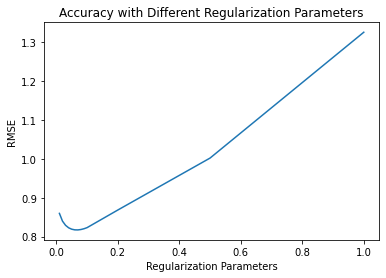

In [113]:
x = regparam
y = rmse_reg
plt.plot(x, y)
plt.xlabel("Regularization Parameters")
plt.ylabel("RMSE")
plt.title("Accuracy with Different Regularization Parameters")
plt.show()

Next, we plot the graph between RMSE and regularization parameters to draw the relationship between them. 

In [119]:
regparam = 0.06
rmse_rank = []
rank = range(10, 70, 10)

for r in rank:
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          regParam=regparam, coldStartStrategy="drop", rank=r)
    rmse = fit_and_evaluate_mf(als, training_baseline, validation_baseline)
    rmse_rank.append(rmse)
    print("Rank =", r, "Root-mean-square error = ", str(rmse))

Rank = 10 Root-mean-square error =  0.8175012859932174
Rank = 20 Root-mean-square error =  0.8143559744235864
Rank = 30 Root-mean-square error =  0.8124286863377664
Rank = 40 Root-mean-square error =  0.8117555603341003
Rank = 50 Root-mean-square error =  0.8113624465964935
Rank = 60 Root-mean-square error =  0.8118619624523569


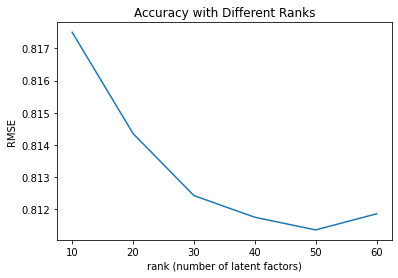

In [120]:
x = rank
y = rmse_rank
plt.plot(x, y)
plt.xlabel("rank (number of latent factors)")
plt.ylabel("RMSE")
plt.title("Accuracy with Different Ranks")
plt.show()

As shown above, keeping regularization parameter 0.06, the RMSE of the model gradually decreases and increase at the end as rank increases from 10 to 60, with slight fluctuations along the line. However, increasing the number of ranks increase the runtime as well. In order to balance between the accuracy and the runtime, we decide to use the rank of 40. 

In [122]:
# Model-based: Matrix Factorization
als = ALS(rank=40, regParam=0.06, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")
rmse_base_mf, ndcg_base_mf, item_coverage_base_mf, predictions_base_mf = fit_and_evaluate_mf(als, 
                                                                        training_baseline, test_baseline, ndcg = True, coverage = True)
print("Root-mean-square error (RMSE) = ", str(rmse_base_mf))
print("NDCG = ", str(ndcg_base_mf))
print("Item Coverage = ", item_coverage_base_mf)

Root-mean-square error (RMSE) =  0.8132312741328172
NDCG =  0.794656507214481
Item Coverage =  0.7025664527956004


From the above analysis, evaluations on the MF Baseline Model is: 

RMSE = 0.813

NDCG = 0.795

Item Coverage = 0.703

### User Rating Counts Distribution

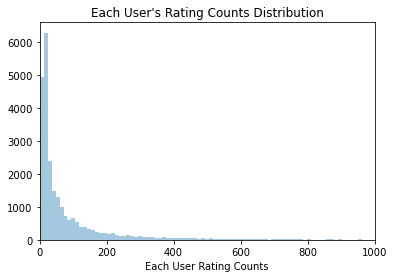

In [123]:
# Visualize the distribution of the user rating counts in the sample
user_rating_count = sample_large['userId'].value_counts().tolist()
sns.distplot(user_rating_count, bins=400, axlabel = "Each User Rating Counts",label='frequency', kde = False).set_title("Each User's Rating Counts Distribution")
plt.xlim(0, 1000)
plt.show()

## Hybrid Model Construction
As we mentioned before, we will build a switching hybrid model that applys different algorithms to different group of users based on  their historical ratings in the record. For users with only a few ratings or cold-start users, we apply content-based algorithm to build their prediction and recommendation, Users with a moderate amount of ratings are funneled into a matrix facterization model. Finally, we utilize facterization machine to power users who have rated a lot of movies in our dataset. 



We will first write a function to divide users into three groups based on their number of ratings in our dataset. The threshold for number of ratings for each group will be a hyper-parameter tuned in the contenct-based algorithm.

In [31]:
# Split user into groups: users with low rating count, users with medium rating count, users with large rating count 
def split_user(dataset, few_num, large_num):
    """ 
    This function split the users into three groups based on their number of ratings in the sample data.
    Args:
      dataset: sample dataset.
      few_num: users with number of ratings less this number will be applied content based algorithm.
      large_num: users with number of ratings more than this number will be applied facterization machine.
    Return:
      dataset and user list for each algorithms in the hybrid model.
    """
    rate_count = dataset['userId'].value_counts()
    user_content = []
    user_mf = []
    user_fm = []
    full_user_list = list(dataset.userId.unique())
    for i in full_user_list:
        count = rate_count[i]
        if count <= few_num:
            user_content.append(i)
        elif count <= large_num:
            user_mf.append(i)
        else:
            user_fm.append(i)
    df_content = dataset[dataset['userId'].isin(user_content)]
    df_mf = dataset[dataset['userId'].isin(user_mf)]
    df_fm = dataset[dataset['userId'].isin(user_fm)]
    return user_content, df_content, user_mf, df_mf, user_fm, df_fm

### Content-based Algorithm Implementation and Hyper-parameter Tuning

we will first write a function to compute the similarity between each movie in the sample data and output a movie similarity matrix, which will then be used in the content-based algorithm.

In [32]:
def movie_similarity_matrix(dataset):
    """
    This function imput a dataset an compute a movie similarity matrix for all movies in the dataset
    Args:
      dataset: sample dataset used
    Return: 
      movie similarity matrix for all movies in the dataset
    """
    genre_list = set()
    length = len(dataset)
    movie_id = list(dataset['movieId'])
    for i in range(length):
        sample_list = dataset['genres'][i]
        genre_list.update(sample_list)
    genre_list = list(genre_list)
    genre_list.pop(0)
    X = pd.DataFrame(0, index = movie_id, columns = genre_list)
    for movie in movie_id:
        genre_ind_list = dataset.loc[dataset['movieId'] == movie].genres.tolist()[0]
        for j in genre_ind_list:
            if j != '':
                X.loc[movie, j] = 1
    # compute cosine similarity matrix
    cosine_sim = linear_kernel(X, X) 
    return genre_list , X, cosine_sim 

Now we cam implement the content-based algorithm.




In [33]:
def content_base_model(movie_sample, df_content, movie_id_list, user_content, dataset):
    """This function produces the dataset with predicted ratings on movies that the user has rated and the one on all movies in the dataset

    Args:
        movie_sample: all movies in the sample set with genres
        df_content: rating matrix for users with less than certain rating counts
        movie_id_list: all movie ids in the sample set
        user_content: list of users with less than certain rating counts
        dataset: validation/test dataset

    Returns:
        dataset with user id, movie id, actual rating, and predicted rating
        dataset containing predicted ratings of users on all movies in the sample
    """    
    genre_list, X, cos = movie_similarity_matrix(movie_sample)
    
    # Build Item Profile
    item_profile = X
    original_movie_id = movie_sample['movieId']
    item_profile.columns = genre_list
    item_profile = item_profile.set_index(original_movie_id)
    item_profile = item_profile.sort_index(ascending = True)
    
    # Build User Profile
    content_df_length = len(df_content)
    user_profile = pd.DataFrame(0, index = movie_id_list, columns = user_content)
    for i in range(content_df_length):
        user_id = int(df_content.iloc[i]['userId'])
        movie_id = int(df_content.iloc[i]['movieId'])
        r = df_content.iloc[i]['rating']
        user_profile.loc[movie_id, user_id] = r
    user_profile = user_profile.sort_index(ascending = True)
    
    # Build User-Movie Prediction
    user_profile_predict = pd.DataFrame(0, index = movie_id_list, columns = user_content)
    for i in user_content:
        working_df = item_profile.mul(user_profile[i], axis=0) 
        working_df.replace(0, np.NaN, inplace = True)
        test = working_df.mean(axis=0, numeric_only=True)
        new_working_df = item_profile.mul(test, axis=1)
        new_working_df.replace(0, np.NaN, inplace=True)
        test2 = new_working_df.mean(axis=1, numeric_only=True)
        test2.replace(np.NaN, 0, inplace=True)
        user_profile_predict[i] = test2
        
    # Produce the result as a dataset with prediction
    length = len(dataset)
    content_final_df = dataset.copy()
    predict_list = []
    for i in range(length):
        actual_r = dataset.iloc[i]['rating']
        movie_id = int(dataset.iloc[i]['movieId'])
        user_id = int(dataset.iloc[i]['userId'])
        if user_id in user_content:
            predicted_r = user_profile_predict.loc[movie_id, user_id]
            predict_list.append(predicted_r)
    content_final_df['prediction'] = predict_list
    return content_final_df, user_profile_predict

#### Hyper-parameter Tuning for Content-based Algorithm on Number of Ratings, which is used to divide users into groups that are applied different algorithms.

In [127]:
few_number_list_tuning = [7, 10, 13]
fewer_rating_ratio_list_tuning = []
rmse_content_list_tuning = []
for i in few_number_list_tuning:
    few_num_tuning = i
    large_num_tuning = 190
    fewer_rating_ratio_tuning = len([i for i in user_rating_count if i<=few_num_tuning])/user_num
    fewer_rating_ratio_list_tuning.append(fewer_rating_ratio_tuning)
    
    # Split the sample data into the one for content-based and the one for matrix factorization
    few_num_tuning = int(few_num_tuning * train_ratio)
    large_num_tuning = int(large_num_tuning * train_ratio)
    user_content_tuning, df_content_tuning, user_mf_tuning, df_mf_tuning, user_fm_tuning, df_fm_tuning = split_user(train_df, 
                                                                                                                    few_num_tuning, 
                                                                                                                    large_num_tuning)
    df_content_validation_tuning = validation_df[validation_df['userId'].isin(user_content_tuning)]
    df_content_validation_length_tuning = len(df_content_validation_tuning)
    content_f_df, user_profile = content_base_model(movie_sample, df_content_tuning, movie_id_list, 
                                            user_content_tuning, df_content_validation_tuning)
    rmse_tuning = get_rmse(content_f_df)
    rmse_content_list_tuning.append(rmse_tuning)

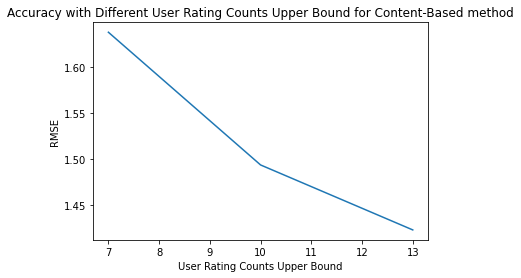

In [128]:
x = few_number_list_tuning
y = rmse_content_list_tuning
plt.plot(x, y)
plt.xlabel("User Rating Counts Upper Bound")
plt.ylabel("RMSE")
plt.title("Accuracy with Different User Rating Counts Upper Bound for Content-Based method")
plt.show()

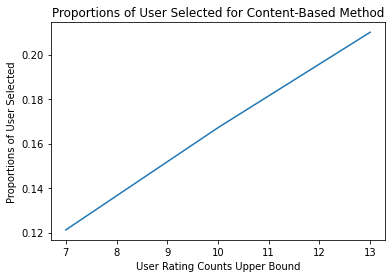

In [129]:
x = few_number_list_tuning
y = fewer_rating_ratio_list_tuning
plt.plot(x, y)
plt.xlabel("User Rating Counts Upper Bound")
plt.ylabel("Proportions of User Selected")
plt.title("Proportions of User Selected for Content-Based Method")
plt.show()

Even though the increase in user rating counts upper bound could decrease RMSE thus increasing the accuracy of the model on validation data set, it also create a significant increase in the proportions of users evaluated by the content-based method and the running time. To balance between the accuracy and running time as well as the proportions of users evaluated by the content-based model, we decide to use the rating count upper bound of 10 for our content-based method. 

#### User Spliting Threshold
After tuning the number of ratings, we can now divide users with rating numbers less than 10 into the "cold-start" group that will be applied content-based algorithm. We will also divide poeple with number of ratings greater than 190 into "power-user" group that will be applied facterization machine. We split user group now before since we need to use the splitting groups to tune hyper-parameters for matrix facterization and facterization machine algorithms. 

In [34]:
few_num = 10
large_num = 190
fewer_rating_ratio = len([i for i in user_rating_count if i<=few_num])/user_num
medium_rating_ratio = len([i for i in user_rating_count if (i<=large_num and i> few_num)])/user_num
large_rating_ratio = len([i for i in user_rating_count if  i> large_num])/user_num
print("Number of user with rating count at most %s " % few_num, fewer_rating_ratio)
print("Number of user with rating count more than %s" % few_num, " and at most %s" % large_num, medium_rating_ratio)
print("Number of user with rating count more than %s" % large_num, large_rating_ratio)

Number of user with rating count at most 10  0.16715378147896065
Number of user with rating count more than 10  and at most 190 0.7045281659126397
Number of user with rating count more than 190 0.12831805260839974


In [35]:
# Split the sample data into the one for content-based and the one for matrix factorization
few_num = int(few_num * train_ratio)
large_num = int(large_num * train_ratio)
user_content, df_content, user_mf, df_mf, user_fm, df_fm = split_user(train_df, few_num, large_num)

# Get the validation dataset for Content-Based
df_content_validation = validation_df[validation_df['userId'].isin(user_content)]
df_content_validation_length = len(df_content_validation)

# Also get the validation and test dataset for Matrix Factorization
df_mf_validation = validation_df[validation_df['userId'].isin(user_mf)]
df_mf_validation_length = len(df_mf_validation)

# Get the validation and test dataset for Factorization Machine
df_fm_validation = validation_df[validation_df['userId'].isin(user_fm)]
df_fm_validation_length = len(df_fm_validation)

### Matrix Facterization Algorithm for users with moderate amount of ratings.



#### Systematic Testing on Hyper Parameters of Model-Based Method

In [125]:
# Prepare the dataset for Spark
train_mf = spark.createDataFrame(df_mf)
validation_mf = spark.createDataFrame(df_mf_validation)

In [126]:
rank = 10
regparam = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1.0]
rmse_reg = []
for reg in regparam:
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          regParam=reg, coldStartStrategy="drop", rank=rank)
    rmse = fit_and_evaluate_mf(als, train_mf, validation_mf)
    rmse_reg.append(rmse)
    print("Reg =", reg, "Root-mean-square error = ", str(rmse))

Reg = 0.01 Root-mean-square error =  1.0185172051815492
Reg = 0.02 Root-mean-square error =  0.9718857172505573
Reg = 0.03 Root-mean-square error =  0.9437528029248843
Reg = 0.04 Root-mean-square error =  0.9239504467606402
Reg = 0.05 Root-mean-square error =  0.9095749147967452
Reg = 0.06 Root-mean-square error =  0.8989538631866985
Reg = 0.07 Root-mean-square error =  0.891124709943493
Reg = 0.08 Root-mean-square error =  0.8852953145006512
Reg = 0.09 Root-mean-square error =  0.8810170431927196
Reg = 0.1 Root-mean-square error =  0.878083837868042
Reg = 0.2 Root-mean-square error =  0.8947735968991883
Reg = 0.5 Root-mean-square error =  1.0313718978210404
Reg = 1.0 Root-mean-square error =  1.344261491046586


Next, we plot the graph between RMSE and regularization parameters to draw the relationship between them.

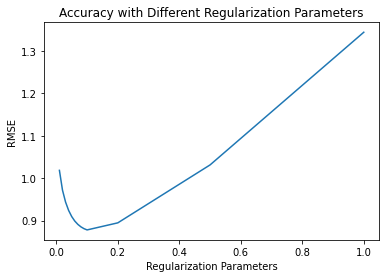

In [72]:
x = regparam
y = rmse_reg
plt.plot(x, y)
plt.xlabel("Regularization Parameters")
plt.ylabel("RMSE")
plt.title("Accuracy with Different Regularization Parameters")
plt.show()

As we can see from the above plot, as we increase the regularization parameter, the RMSE of the model first decreases then increases. With the regularization parameter of 0.1, there is a minimum RMSE value of the model. 

Next, we are going to tune the other hyper parameter, the number of latent parameters (rank). The number of latent parameters represents the number of hidden factors of the dataset. For the movie dataset, hidden factors could be users' ages, sexes, or jobs. Having more hidden factors could increase the accuracy and complexity of the model at the same time. Thus, when tuning this hyper parameter, we aim at finding the balance point between accuracy and runtime.

In [116]:
regparam = 0.1
rmse_rank = []
rank = range(10, 100, 10)

for r in rank:
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          regParam=regparam, coldStartStrategy="drop", rank=r)
    rmse = fit_and_evaluate_mf(als, train_mf, validation_mf)
    rmse_rank.append(rmse)
    print("Rank =", r, "Root-mean-square error = ", str(rmse))

Rank = 10 Root-mean-square error =  0.8780838378680421
Rank = 20 Root-mean-square error =  0.8759982381037924
Rank = 30 Root-mean-square error =  0.8780350125417312
Rank = 40 Root-mean-square error =  0.8752668900029613
Rank = 50 Root-mean-square error =  0.8773805411004477
Rank = 60 Root-mean-square error =  0.876640116775506
Rank = 70 Root-mean-square error =  0.8765469810863279
Rank = 80 Root-mean-square error =  0.8758769489864037
Rank = 90 Root-mean-square error =  0.8765884172344629


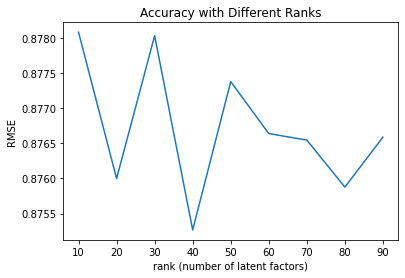

In [118]:
x = rank
y = rmse_rank
plt.plot(x, y)
plt.xlabel("rank (number of latent factors)")
plt.ylabel("RMSE")
plt.title("Accuracy with Different Ranks")
plt.show()

We use the rank of 40. We could tell that the optimal parameter value is with rank equal to 20, regularization parameter equal to 0.1. 

### Factorization Machine for users with large amount of ratings


We implement the Factorization Machine to predict the rating of a movie by a user through package pyFM. The model may perform better than the Matrix Factorization model in the sense that it in addition incorporates side information in the training data set ('movie genres' in our case) to estimate movie ratings for users. 

We start by expanding the genre information into our dataframe and using dummy variables to represent the 19 kinds of genres, that is, if the movie belongs to a genre 'A', then the value to that corresponding column is 1, otherwise 0 (in function 'prepare_data_fm'). Then we convert the user id, movie id, movie ratings and movie genre information to the format of one hot encoding using OneHotEncoder function to train the model.


In [37]:
def OneHotEncoding(train, test):
    encoder = OneHotEncoder(handle_unknown='ignore').fit(train)
    train_onehot = encoder.transform(train)
    test_onehot = encoder.transform(test)
    return train_onehot, test_onehot

Call helper functions to transform data into the proper form that can be used for facterization machine.

In [38]:
# Prepare data for Factorization Machine
# use FM validation data for tuning
X_train, y_train = prepare_data_fm(movie_sample,df_fm)
X_val, y_val = prepare_data_fm(movie_sample,df_fm_validation)

train_onehot, val_onehot = OneHotEncoding(X_train, X_val)

#### Systematic Testing on Hyper Parameters of Factorization Machine

To improve the accuracy of the model, we want to find the best parameter set. However, due to time limitation, we only focus on determining the dimentionality of the factorized 2-way interactions in the model fitting process. We compute the RMSE for the model separately using 'num_factor' of 8, 10, and 12. We still use rmse as the evaluation error metrics of the validation. After that, we conduct a plot to display the result.

In [131]:
# Tuning parameter 'num_factor'
rmse_tuning_num_factors = []
param = [8, 10, 12]
for i in param:
    fm = pylibfm.FM(num_factors=i, num_iter=10, verbose=True, task="regression", 
                    initial_learning_rate= 0.0005, learning_rate_schedule="optimal")
    rmse = fit_and_evaluate_fm(fm, train_onehot, val_onehot, X_train, 
                               X_val, y_train, y_val)
    rmse_tuning_num_factors.append(rmse)

In [135]:
# print out the results
for i in range(len(param)):
    print("factor number =", param[i], 
          "Root-mean-square error = ", str(rmse_tuning_num_factors[i]))

factor number = 8 Root-mean-square error =  0.8973683247366779
factor number = 10 Root-mean-square error =  0.8423116993426385
factor number = 12 Root-mean-square error =  0.8336271820894319


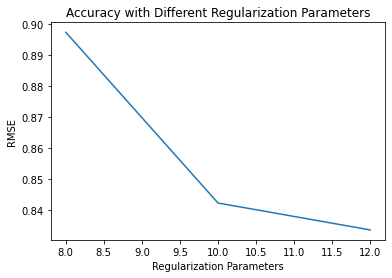

In [136]:
x = param
y = rmse_tuning_num_factors
plt.plot(x, y)
plt.xlabel("Regularization Parameters")
plt.ylabel("RMSE")
plt.title("Accuracy with Different Regularization Parameters")
plt.show()

From the tuning result and graph, as the number of factors increases, RMSE decreases. However, the higher dimentionality takes a lot of memory and time. To balance running time and accuracy, we still choose 10 as the num_factor.

## Final Model

In [141]:
# Evaluate the model performances on test set

# Split users to 3 groups using content-based, matrix factorization, and factorization machine respectively
test_df_content = test_df[test_df['userId'].isin(user_content)]
test_df_mf = test_df[test_df['userId'].isin(user_mf)]
test_df_fm = test_df[test_df['userId'].isin(user_fm)]

# Transform the dataset for MF into Spark formats
test_mf = spark.createDataFrame(test_df_mf)

# Tranform the dataset for FM into OneHotEncoding Format

X_test, y_test = prepare_data_fm(movie_sample,test_df_fm)
train_onehot, test_onehot = OneHotEncoding(X_train, X_test)
   

# Apply models on test datasets

# Content-Based Method
content_final_df, user_profile_predict= content_base_model(movie_sample, df_content, movie_id_list, user_content, test_df_content)
rmse_content = get_rmse(content_final_df)
ndcg_content = get_ndcg(content_final_df)
item_coverage_content, top_n_content = item_coverage_content(user_profile_predict, test_df_content, movie_id_list, n = 10)

# Matrix Factorization Method
als_final = ALS(rank=40, regParam=0.1, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
rmse_mf, ndcg_mf, item_coverage_mf, predictions_mf = fit_and_evaluate_mf(als_final, train_mf, test_mf, ndcg = True, coverage = True)
top_n_mf = get_top_n_mf(als_final, train_mf, test_mf, n=10)
predictions_mf = predictions_mf.toPandas()


# Factorization Machine Method
fm = pylibfm.FM(num_factors=10, num_iter=10, verbose=True, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
rmse_fm, ndcg_fm, item_cov_fm, top10_fm, predictions_fm = fit_and_evaluate_fm(fm, train_onehot, test_onehot, X_train, X_test, 
                           y_train, y_test, ndcg = True, coverage = True)
topn_fm = predict_and_rcmd_result_fm(predictions_fm)

# Combine as a group to analyze the total RMSE, NDCG, and Item Coverage
content_final_df.columns = ['uid', 'mid', 'rating', 'prediction']
predictions_mf.columns = ['uid', 'mid', 'rating', 'prediction']
predictions_fm.columns = ['uid', 'mid', 'rating', 'prediction']
total_test_df = pd.concat([content_final_df, predictions_mf])
total_test_df = pd.concat([total_test_df, predictions_fm])
total_test_df = total_test_df.reset_index(drop=True)

# Get top n predictions
top_n_content.columns = ['uid', 'top_n']
top_n_mf.columns = ['uid', 'top_n']
topn_fm.columns = ['uid', 'top_n']
total_top_n = pd.concat([top_n_content, top_n_mf])
total_top_n = pd.concat([total_top_n, topn_fm])
total_top_n = total_top_n.reset_index(drop=True)

# Evaluate the whole dataset
rmse_total = get_rmse(total_test_df)
ndcg_total = get_ndcg(total_test_df)
df_length = len(total_top_n)
movie_recommended = set()
for i in range(df_length):
    movie_list = total_top_n.iloc[i]['top_n']
    for movie_id in movie_list: 
        movie_recommended.add(movie_id)
item_coverage_total = len(movie_recommended)/len(movie_id_list)


In [142]:
d = {"RMSE": [popular_rmse, rmse_base_mf, rmse_total], 
     "NDCG": [popular_ndcg, ndcg_base_mf, ndcg_total], 
     "Item Coverage": [np.NaN, item_coverage_base_mf, item_coverage_total]}
product = pd.DataFrame(data = d, index = ["Popularity Baseline", "Matrix Factorization Baseline", "Hybrid System"])
print(product)

                                   RMSE      NDCG  Item Coverage
Popularity Baseline            1.247556  0.773401            NaN
Matrix Factorization Baseline  0.813231  0.794657       0.702566
Hybrid System                  0.867772  0.773049       0.848084


### Final Result Comparison
Now we finally get the result for our final hybrid model. If we look at the values of the evaluation metrics for the hybrid model, our hybrid model has a relatively small RMSE at aroung 0.87 and a relatively high NDCG rate at aroung 0.78 and item coverage rate at around 0.84, This result shows that our hybrid model beats the baseline model on popularity with a RMSE at 1.23 and a NDCG value at 0.77. Though we do not compute the item coverage rate for the baseline model on popularity, the item coverage rate for our hybrid model is definitely higher that the baseline model on popularity. This is because the baseline on popularity recommends same top n popular movies for all users and the item coverage is n/(total movie number), which is a relatively small number. Therefore, our hybrid model performs much better the the baseline model on popularity. 

However, our hybrid model doesn't beat the single matrix facterization model as a baseline model regarding RMSE and NDCG value. This is explainable because implement content-based algorithm and facterizaion machine algorithm in our hybrid model.

For the content-based algorithm, we use genre to generate the movie similarity matrix. However, the total number of genres that we can use is only 19, which does not contain all the movie genre. Besides, only genre itself is less informative than short reviews or descriptive tags to summerize the characteristics of a movie. Moreover, in order to use content-based algorithm to solve user cold-start problem, we need the user profile to be informative enough to generate the interaction sbetween users and movie genres. However, since we apply content-based algorithm for users with less than 10 ratings, we cannot generate a detailed profile for these users and we have no access to a third party data matching. As for the facterization machine algorithm, we only add genre as a new variable in the model. More varaibles such as movie released year and tags can be include and new hyper-parameter can be tuned to generate a more accurate model.

However, our model beats the matrix facterization baseline model regarding the item coverage rate since we combine the results of all three algorithms. 

Overall, our switching hybrid model performs relatively well and meets our expectation.

## Potential Model Improvement

#### User Profile
Even though our switching hybrid model works for users in different groups based on their number of ratings, an informative profile for cold-start users or users with very few ratings is preferred. This is bacuase in the step of building user profile in the content-based algorithm, a more complete user profile will give more information on the interactions and preferences of users on movie and genre and thus will greatly increasing the accuracy or our content-based algorithm. In practical business operation, we can access this profile information through third party data matching.

#### More Data on Movies for Content-based and Facterization Machine Algorithm
Currently, due to run-time and computing power constriant, we only add genres of movies in the content-based and facterization machine algorithm. However, only genre is not informative enough for a comprehensive model in practise and more information and reviews of movies can be used in the content-based and facterization machine algorithm. For example, if a more informative tag or short review is given for each movie, then we can use the information to contruct a complex movie similariry matrix and complete user profile in the content-based algorithm and thus build a more accurate model, but run time complexity is still a factor to be considered while choosing informative message to utilize. Moreover, we can add the released year of each movie in the facterization machine algorithm and enrich the interactions between differnt characteristics of movies.

#### Filtering the final recommendation
In practise, additional laws and rules such as "do not recommend horror movies to kids" should be utilized in the recommendation system. To achieve this, we need to add a filtering method on the recommendation built by our model and update it before giving the final recommendation. To build the filering method, more information on movie and user profile is needed. 

#### Dynamic Update and Recommendaiotn
In real-world buisiness operation, new movies come out frequently and users' taset may change day by day. Therefore, practical recommendation system needs to be dynamic. Our content-based model can solve recommendation for new movies once the information of movies such as genre is provided. However, our model can still be improved by thinking how to add users' most recent ratings as well as enriching the user profile for the existing recommendation system and update our prediction algorithms and the recommadation list accordingly.